### Preprocessing - Time Series<a id='preprocessing'>

## Contents<a id='Contents'></a>
* [Time Series - Preprocessing](#preprocessing)
  * [Contents](#Contents)
    * [Imports](#imports)
    * [Load The EDA - Crime reports Data](#load_data)
    * [Preparing Time Series for the crime Theft](#choosing_theft)
        * [Daily level dataset preparation](#daily_prep)
        * [Group Aggregarion](#gp_agg)
        * [TIMES SERIES Preprocessing for Theft](#preprocessing_begins)
          * [Decomposition](#decomposition)
              * [Testing for Stationarity using KPSS](#stationarity_test)
              * [ADFuller test to test for stationarity](#adfuller_test)
           * [Train_test split](#train_test_split)
      * [Simple Forecast Methods](#simple_forecast_methods)
              * [NAIVE Method](#naive_method)
              * [Simple Average Method](#avg_method)
              * [Moving Average Method](#moving_avg_method)
              * [Simple Exponential Smoothing Method](#simple_exponential_method)
              * [Autocorrelation and Partial Autocorrelation plots](#acf_pacf)
              * [ARIMA Modeling](#arima_modeling)
      * [auto_arima grid search to find the best paramaters for our model](#auto_arima_grid)
      * [Linear Regression](#linear_regression)
        
    * [Summary of Preprocessing](#summary)
     

### Imports<a id='imports'>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pyarrow as pa
import pyarrow.parquet as pq
from pylab import rcParams
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
from sklearn.metrics import mean_squared_error
from math import sqrt

# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima # for determining ARIMA orders

import warnings
warnings.filterwarnings('ignore')

### Load Data<a id='load_data'>

In [2]:
#load dataset
df_crimes_summary = pd.read_csv('crimes_summary.csv', parse_dates=['occurred_date_time'])

In [3]:
#this dataframe list top ten crimes which occur in the zip code 78701 under census_tract 11 which falls under council_district 9.
#Top ten crimes are : ASSAULT BY CONTACT,ASSAULT WITH INJURY,BURGLARY OF VEHICLE,CRIMINAL MISCHIEF,DISTURBANCE - OTHER,DWI,POSS OF DRUG PARAPHERNALIA,THEFT,VIOL CITY ORDINANCE - OTHER,WARRANT ARREST NON TRAFFIC

In [4]:
df_crimes_summary.head()

incident_report_number           crime_type  ucr_code family_violence  \
0             20223650465  ASSAULT WITH INJURY       900               N   
1             20223650192                  DWI      2100               N   
2             20223641477   ASSAULT BY CONTACT       902               N   
3             20223641378  DISTURBANCE - OTHER      3401               N   
4             20223640858  ASSAULT WITH INJURY       900               N   

                          location_type                     address  zip_code  \
0  HWY / ROAD / ALLEY/ STREET/ SIDEWALK          700 BLOCK E 7TH ST     78701   
1  HWY / ROAD / ALLEY/ STREET/ SIDEWALK  E 9TH ST / N IH 35 SVRD SB     78701   
2  HWY / ROAD / ALLEY/ STREET/ SIDEWALK                708 E 6TH ST     78701   
3                            RESTAURANT                414 E 6TH ST     78701   
4  HWY / ROAD / ALLEY/ STREET/ SIDEWALK                400 E 8TH ST     78701   

   council_district sector  district  ...  clearance_status  \
0                 9     GE         2  ...                 N   
1                 9     CH         2  ...                 C   
2                 9     GE         2  ...                 N   
3                 9     GE         2  ...               NaN   
4                 9     GE         1  ...                 N   

            clearance_date  occurred_date_time   reported_date_time     month  \
0  2023-01-03T00:00:00.000 2022-12-31 09:24:00  2022-12-31 09:24:00  December   
1  2022-12-31T00:00:00.000 2022-12-31 02:39:00  2022-12-31 02:39:00  December   
2  2023-01-03T00:00:00.000 2022-12-30 23:40:00  2022-12-30 23:40:00  December   
3                      NaN 2022-12-30 22:28:00  2022-12-30 23:01:00  December   
4  2023-01-04T00:00:00.000 2022-12-30 15:55:00  2022-12-30 15:55:00  December   

   year hour year_month occurred_day cal_month  
0  2022    9    2022-12           31        12  
1  2022    2    2022-12           31        12  
2  2022   23    2022-12           30        12  
3  2022   22    2022-12           30        12  
4  2022   15    2022-12           30        12  

[5 rows x 27 columns]

In [5]:
df_crimes_types=df_crimes_summary[['occurred_date_time','crime_type','family_violence','hour','occurred_day','cal_month','year_month','year']]

In [6]:
df_crimes_types.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30680 entries, 0 to 30679
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   occurred_date_time  30680 non-null  datetime64[ns]
 1   crime_type          30680 non-null  object        
 2   family_violence     30680 non-null  object        
 3   hour                30680 non-null  int64         
 4   occurred_day        30680 non-null  int64         
 5   cal_month           30680 non-null  int64         
 6   year_month          30680 non-null  object        
 7   year                30680 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 1.9+ MB


### Preparing Time Series for the crime Theft<a id='choosing_theft'>

In [7]:

df_burglary = df_crimes_types.loc[(df_crimes_types['crime_type'] == 'BURGLARY OF VEHICLE')]

In [8]:
df_burglary.shape

(2963, 8)

In [9]:
df_burglary.head(5)

occurred_date_time           crime_type family_violence  hour  \
5  2022-12-30 00:00:00  BURGLARY OF VEHICLE               N     0   
12 2022-12-27 17:00:00  BURGLARY OF VEHICLE               N    17   
27 2022-12-21 16:35:00  BURGLARY OF VEHICLE               N    16   
29 2022-12-21 02:00:00  BURGLARY OF VEHICLE               N     2   
30 2022-12-19 08:46:00  BURGLARY OF VEHICLE               N     8   

    occurred_day  cal_month year_month  year  
5             30         12    2022-12  2022  
12            27         12    2022-12  2022  
27            21         12    2022-12  2022  
29            21         12    2022-12  2022  
30            19         12    2022-12  2022

### Daily level dataset preparation<a id='daily_prep'>

In [10]:
df_burglary['occurred_date'] = pd.to_datetime(df_burglary['occurred_date_time'], format='%Y-%m-%d').dt.floor('D')

In [11]:
df_burglary.head()

occurred_date_time           crime_type family_violence  hour  \
5  2022-12-30 00:00:00  BURGLARY OF VEHICLE               N     0   
12 2022-12-27 17:00:00  BURGLARY OF VEHICLE               N    17   
27 2022-12-21 16:35:00  BURGLARY OF VEHICLE               N    16   
29 2022-12-21 02:00:00  BURGLARY OF VEHICLE               N     2   
30 2022-12-19 08:46:00  BURGLARY OF VEHICLE               N     8   

    occurred_day  cal_month year_month  year occurred_date  
5             30         12    2022-12  2022    2022-12-30  
12            27         12    2022-12  2022    2022-12-27  
27            21         12    2022-12  2022    2022-12-21  
29            21         12    2022-12  2022    2022-12-21  
30            19         12    2022-12  2022    2022-12-19

In [12]:
df_burglary.dtypes

occurred_date_time    datetime64[ns]
crime_type                    object
family_violence               object
hour                           int64
occurred_day                   int64
cal_month                      int64
year_month                    object
year                           int64
occurred_date         datetime64[ns]
dtype: object

In [13]:
df_burglary.year.unique()

array([2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013],
      dtype=int64)

## Subsetting the dataframe where date is between 2022 Jan to 2022 Dec

In [14]:
df_burglary_22 = df_burglary[df_burglary.occurred_date.between('2022-01-01', '2022-12-31')]

In [15]:
df_burglary_22['day'] = df_burglary_22['occurred_date'].apply(lambda x: x.strftime('%A')) 

In [16]:
# extracting the week from the date
df_burglary_22['weekNumber'] = df_burglary_22['occurred_date'].dt.week
 

In [17]:
df_burglary_22.shape

(289, 11)

In [18]:
df_burglary_22.head()

occurred_date_time           crime_type family_violence  hour  \
5  2022-12-30 00:00:00  BURGLARY OF VEHICLE               N     0   
12 2022-12-27 17:00:00  BURGLARY OF VEHICLE               N    17   
27 2022-12-21 16:35:00  BURGLARY OF VEHICLE               N    16   
29 2022-12-21 02:00:00  BURGLARY OF VEHICLE               N     2   
30 2022-12-19 08:46:00  BURGLARY OF VEHICLE               N     8   

    occurred_day  cal_month year_month  year occurred_date        day  \
5             30         12    2022-12  2022    2022-12-30     Friday   
12            27         12    2022-12  2022    2022-12-27    Tuesday   
27            21         12    2022-12  2022    2022-12-21  Wednesday   
29            21         12    2022-12  2022    2022-12-21  Wednesday   
30            19         12    2022-12  2022    2022-12-19     Monday   

    weekNumber  
5           52  
12          52  
27          51  
29          51  
30          51

In [19]:
df_burglary_22['day'].value_counts()

Saturday     49
Sunday       45
Thursday     45
Friday       40
Tuesday      40
Monday       39
Wednesday    31
Name: day, dtype: int64

In [20]:
df_burglary_22['weekNumber'].value_counts()

34    12
10    11
43    11
3     10
26     9
41     9
11     9
2      9
47     9
35     9
20     8
8      8
4      8
44     7
22     7
31     7
9      7
19     7
38     7
36     6
42     6
25     6
24     6
18     6
7      6
6      5
39     5
29     5
50     5
15     5
12     4
52     4
21     4
28     4
48     4
46     4
40     4
23     4
30     4
51     4
1      4
33     3
5      3
49     3
27     2
37     2
16     2
17     2
13     1
14     1
45     1
Name: weekNumber, dtype: int64

In [21]:
df_burglary_22['family_violence'].value_counts()

N    289
Name: family_violence, dtype: int64

### Group Aggregarion<a id='gp_agg'>

In [22]:
df_burglary_22_gp = df_burglary_22.groupby(['weekNumber']).agg(
    burglary_count=('crime_type', 'count'),
    
 ).reset_index()

In [23]:
df_burglary_22_gp.sort_values(by = ['weekNumber'], ascending = [True])

weekNumber  burglary_count
0            1               4
1            2               9
2            3              10
3            4               8
4            5               3
5            6               5
6            7               6
7            8               8
8            9               7
9           10              11
10          11               9
11          12               4
12          13               1
13          14               1
14          15               5
15          16               2
16          17               2
17          18               6
18          19               7
19          20               8
20          21               4
21          22               7
22          23               4
23          24               6
24          25               6
25          26               9
26          27               2
27          28               4
28          29               5
29          30               4
30          31               7
31          33               3
32          34              12
33          35               9
34          36               6
35          37               2
36          38               7
37          39               5
38          40               4
39          41               9
40          42               6
41          43              11
42          44               7
43          45               1
44          46               4
45          47               9
46          48               4
47          49               3
48          50               5
49          51               4
50          52               4

In [24]:
df_burglary_22_gp.describe()

weekNumber  burglary_count
count   51.000000       51.000000
mean    26.392157        5.666667
std     15.285390        2.768875
min      1.000000        1.000000
25%     13.500000        4.000000
50%     26.000000        5.000000
75%     39.500000        7.500000
max     52.000000       12.000000

In [25]:
fig = px.line(df_burglary_22_gp, x='weekNumber', y='burglary_count', title="Count of burglary of vehicles for 52 weeks(year 2022) for zipcode 78701",template='plotly_dark')

fig.show()

In [26]:
df_burglary_22_gp.set_index('weekNumber',inplace=True)

In [27]:
df_burglary_22_gp.head()

burglary_count
weekNumber                
1                        4
2                        9
3                       10
4                        8
5                        3

### TIMES SERIES Preprocessing for Theft<a id='preprocessing_begins'>

In [28]:
y = df_burglary_22_gp['burglary_count']

In [29]:
display(type(y), y.dtype)

pandas.core.series.Series

dtype('int64')

<AxesSubplot:xlabel='weekNumber'>

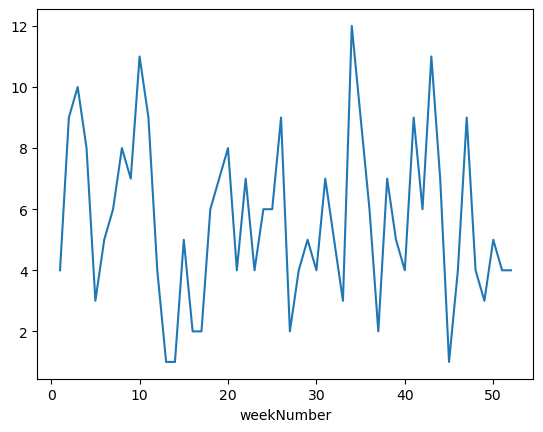

In [30]:
y.plot()

### Decomposition<a id='decomposition'>

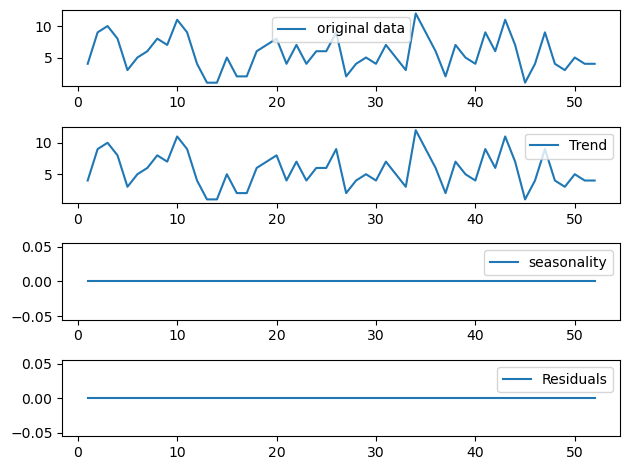

In [31]:
# Import seasonal_decompose 
from statsmodels.tsa.seasonal import seasonal_decompose

# Make a variable called decomposition, and assign it y passed to seasonal_decompose() 
decomposition= seasonal_decompose(x=df_burglary_22_gp['burglary_count'], model='additive', extrapolate_trend='freq', period=1)
#decomposition= seasonal_decompose(y)
# Make three variables for trend, seasonal and residual components respectively. 
# Assign them the relevant features of decomposition 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.subplot(411)
plt.plot(y, label = 'original data')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

### Testing for Stationarity using KPSS<a id='stationarity_test'>
    Kwiatkowski-Phillips-Schmidt-Shin Test

In [32]:
from statsmodels.tsa.stattools import kpss

statistic, p_value, n_lags, critical_values = kpss(df_burglary_22_gp, nlags='auto')

print('Statistic: ', statistic)
print('p-value: ', p_value)
print('Number of Lags: ', n_lags)
print('Critical Values: ', critical_values)

Statistic:  0.10073884626314272
p-value:  0.1
Number of Lags:  0
Critical Values:  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


Since our p-value is higher than 0.05, we should  fail to reject the Null hypothesis and deduce the stationarity of our data.



### ADFuller test to test for stationarity<a id='adfuller_test'>

In [33]:
from statsmodels.tsa.stattools import adfuller

In [34]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}\n')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    print() #empty line for formatting
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is STATIONARY")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is NOT STATIONARY")



In [35]:
adf_test(df_burglary_22_gp)

Augmented Dickey-Fuller Test: 

ADF test statistic     -5.666151e+00
p-value                 9.142041e-07
# lags used             0.000000e+00
# observations          5.000000e+01
critical value (1%)    -3.568486e+00
critical value (5%)    -2.921360e+00
critical value (10%)   -2.598662e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is STATIONARY


### Train_test split<a id='train_test_split'>
Creating train and test file for modeling. <br />


In [36]:
df_burglary_22_gp.reset_index(inplace=True)

In [37]:
df_burglary_22_gp.shape

(51, 2)

# train/test split

In [82]:
# Define threshold date.
threshold_week = 50
mask = df_burglary_22_gp['weekNumber'] <= threshold_week
# Split the data and select `ds` and `y` columns.
df_train = df_burglary_22_gp[mask][['weekNumber', 'burglary_count']]
df_test = df_burglary_22_gp[~ mask][['weekNumber', 'burglary_count']]

In [83]:
df_test

weekNumber  burglary_count
49          51               4
50          52               4

In [84]:
df_train.shape

(49, 2)

In [85]:
df_test.shape

(2, 2)

In [86]:
df_train.set_index('weekNumber',inplace=True)

In [87]:
df_test.set_index('weekNumber',inplace=True)

In [88]:
X_train = df_train

In [89]:
X_test=df_test

In [90]:
X_train.shape, X_test.shape

((49, 1), (2, 1))

In [91]:
y_train, y_test = np.array(range(X_train.shape[0])), np.array(range(X_train.shape[0], df_burglary_22_gp.shape[0]))

In [92]:
y_train.shape,y_test.shape

((49,), (2,))

Text(0.5, 1.0, 'Burglaries train and test sets')

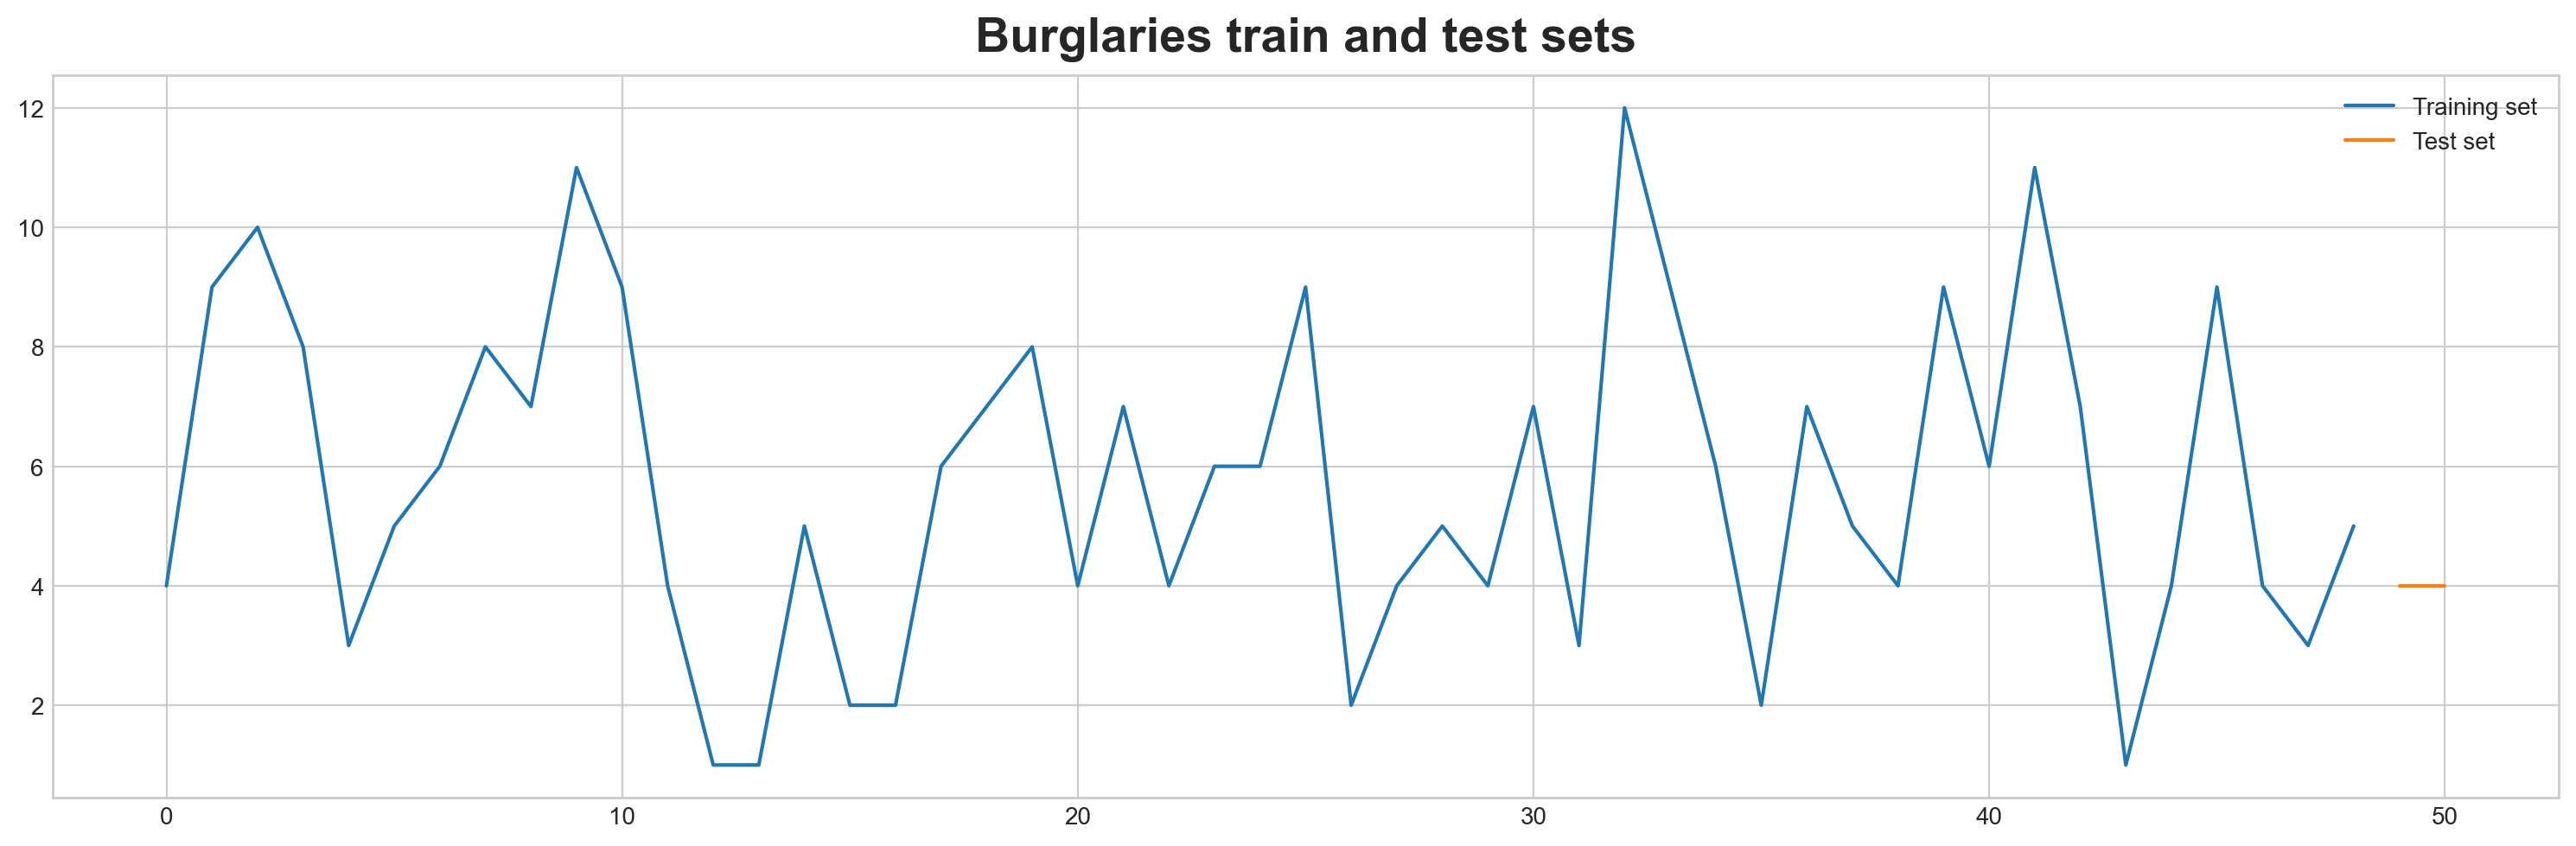

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(y_train, X_train, label='Training set')
ax.plot(y_test, X_test, label='Test set')
plt.legend()
plt.title('Burglaries train and test sets', size=20)

### Simple Forecast Methods<a id='simple_forecast_methods'>
    
Based on Rob J Hyndman and George Athanasopoulos"<br />
Forecasting: Principles and Practice; 3rd Edition<br />
https://otexts.com/fpp3/

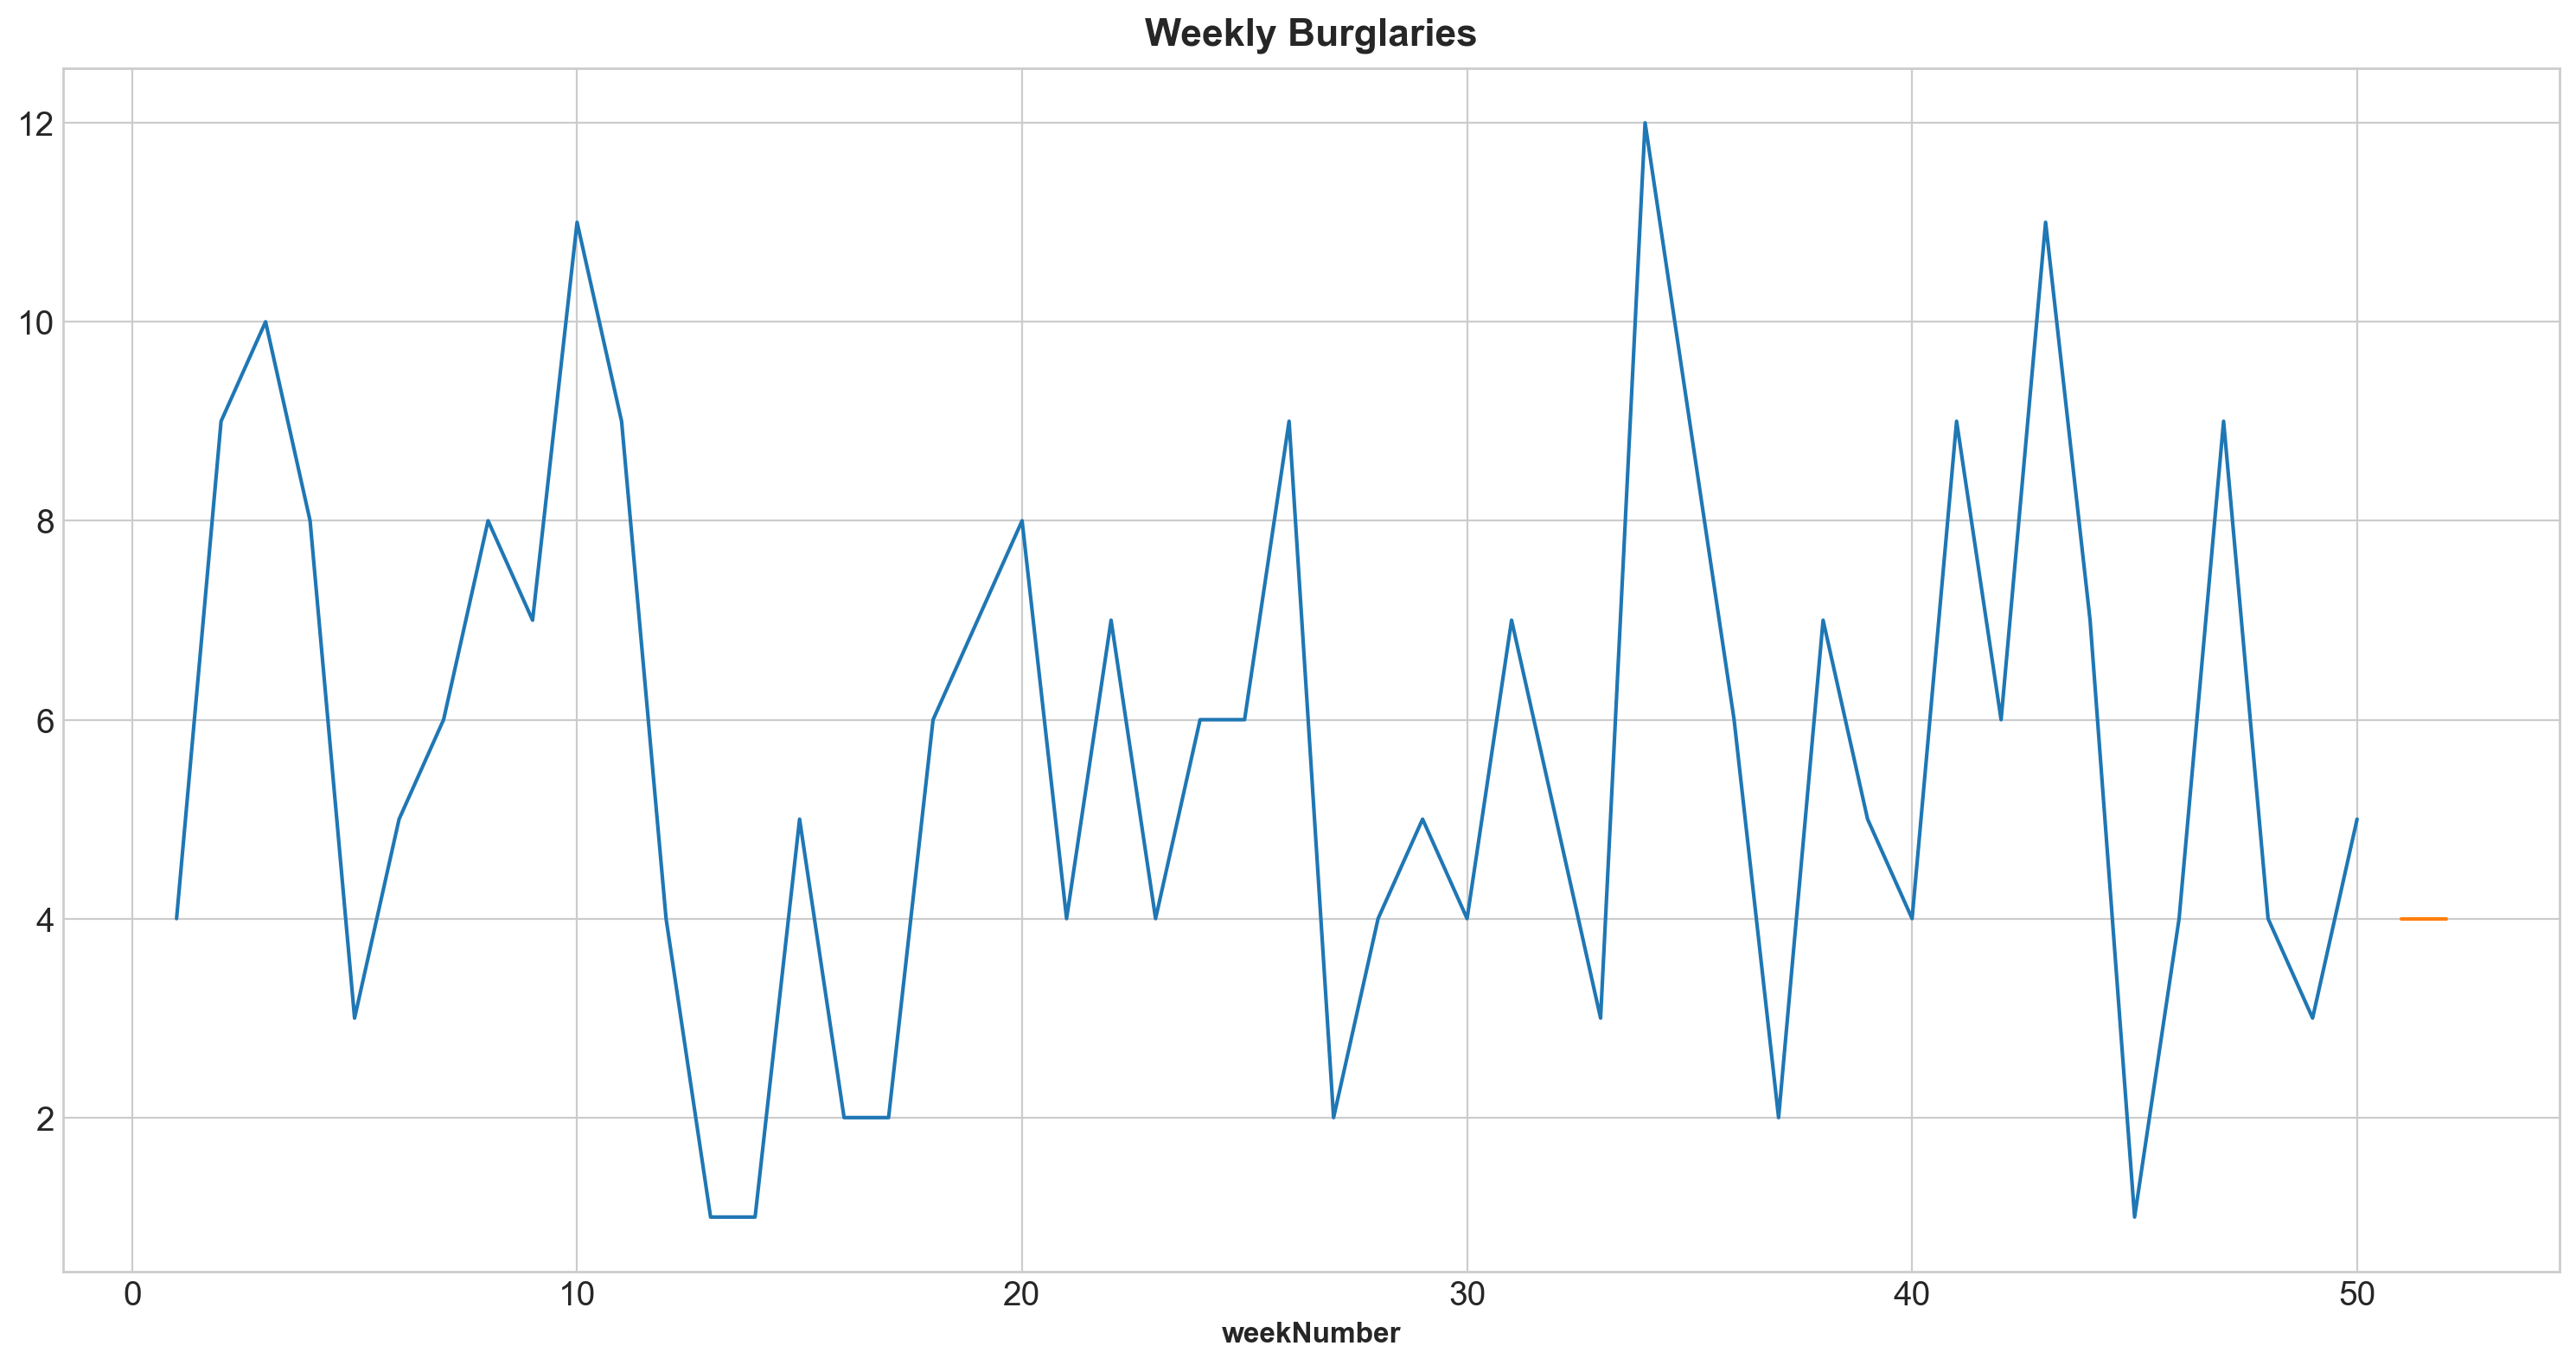

In [94]:
#Plotting data
X_train.burglary_count.plot(figsize=(15,8), title='Weekly Burglaries', fontsize=14)
X_test.burglary_count.plot(figsize=(15,8), title='Weekly Burglaries', fontsize=14)
plt.show()

In [95]:
X_train.index

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35,
            36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
           dtype='int64', name='weekNumber')

### NAIVE Method<a id='naive_method'>

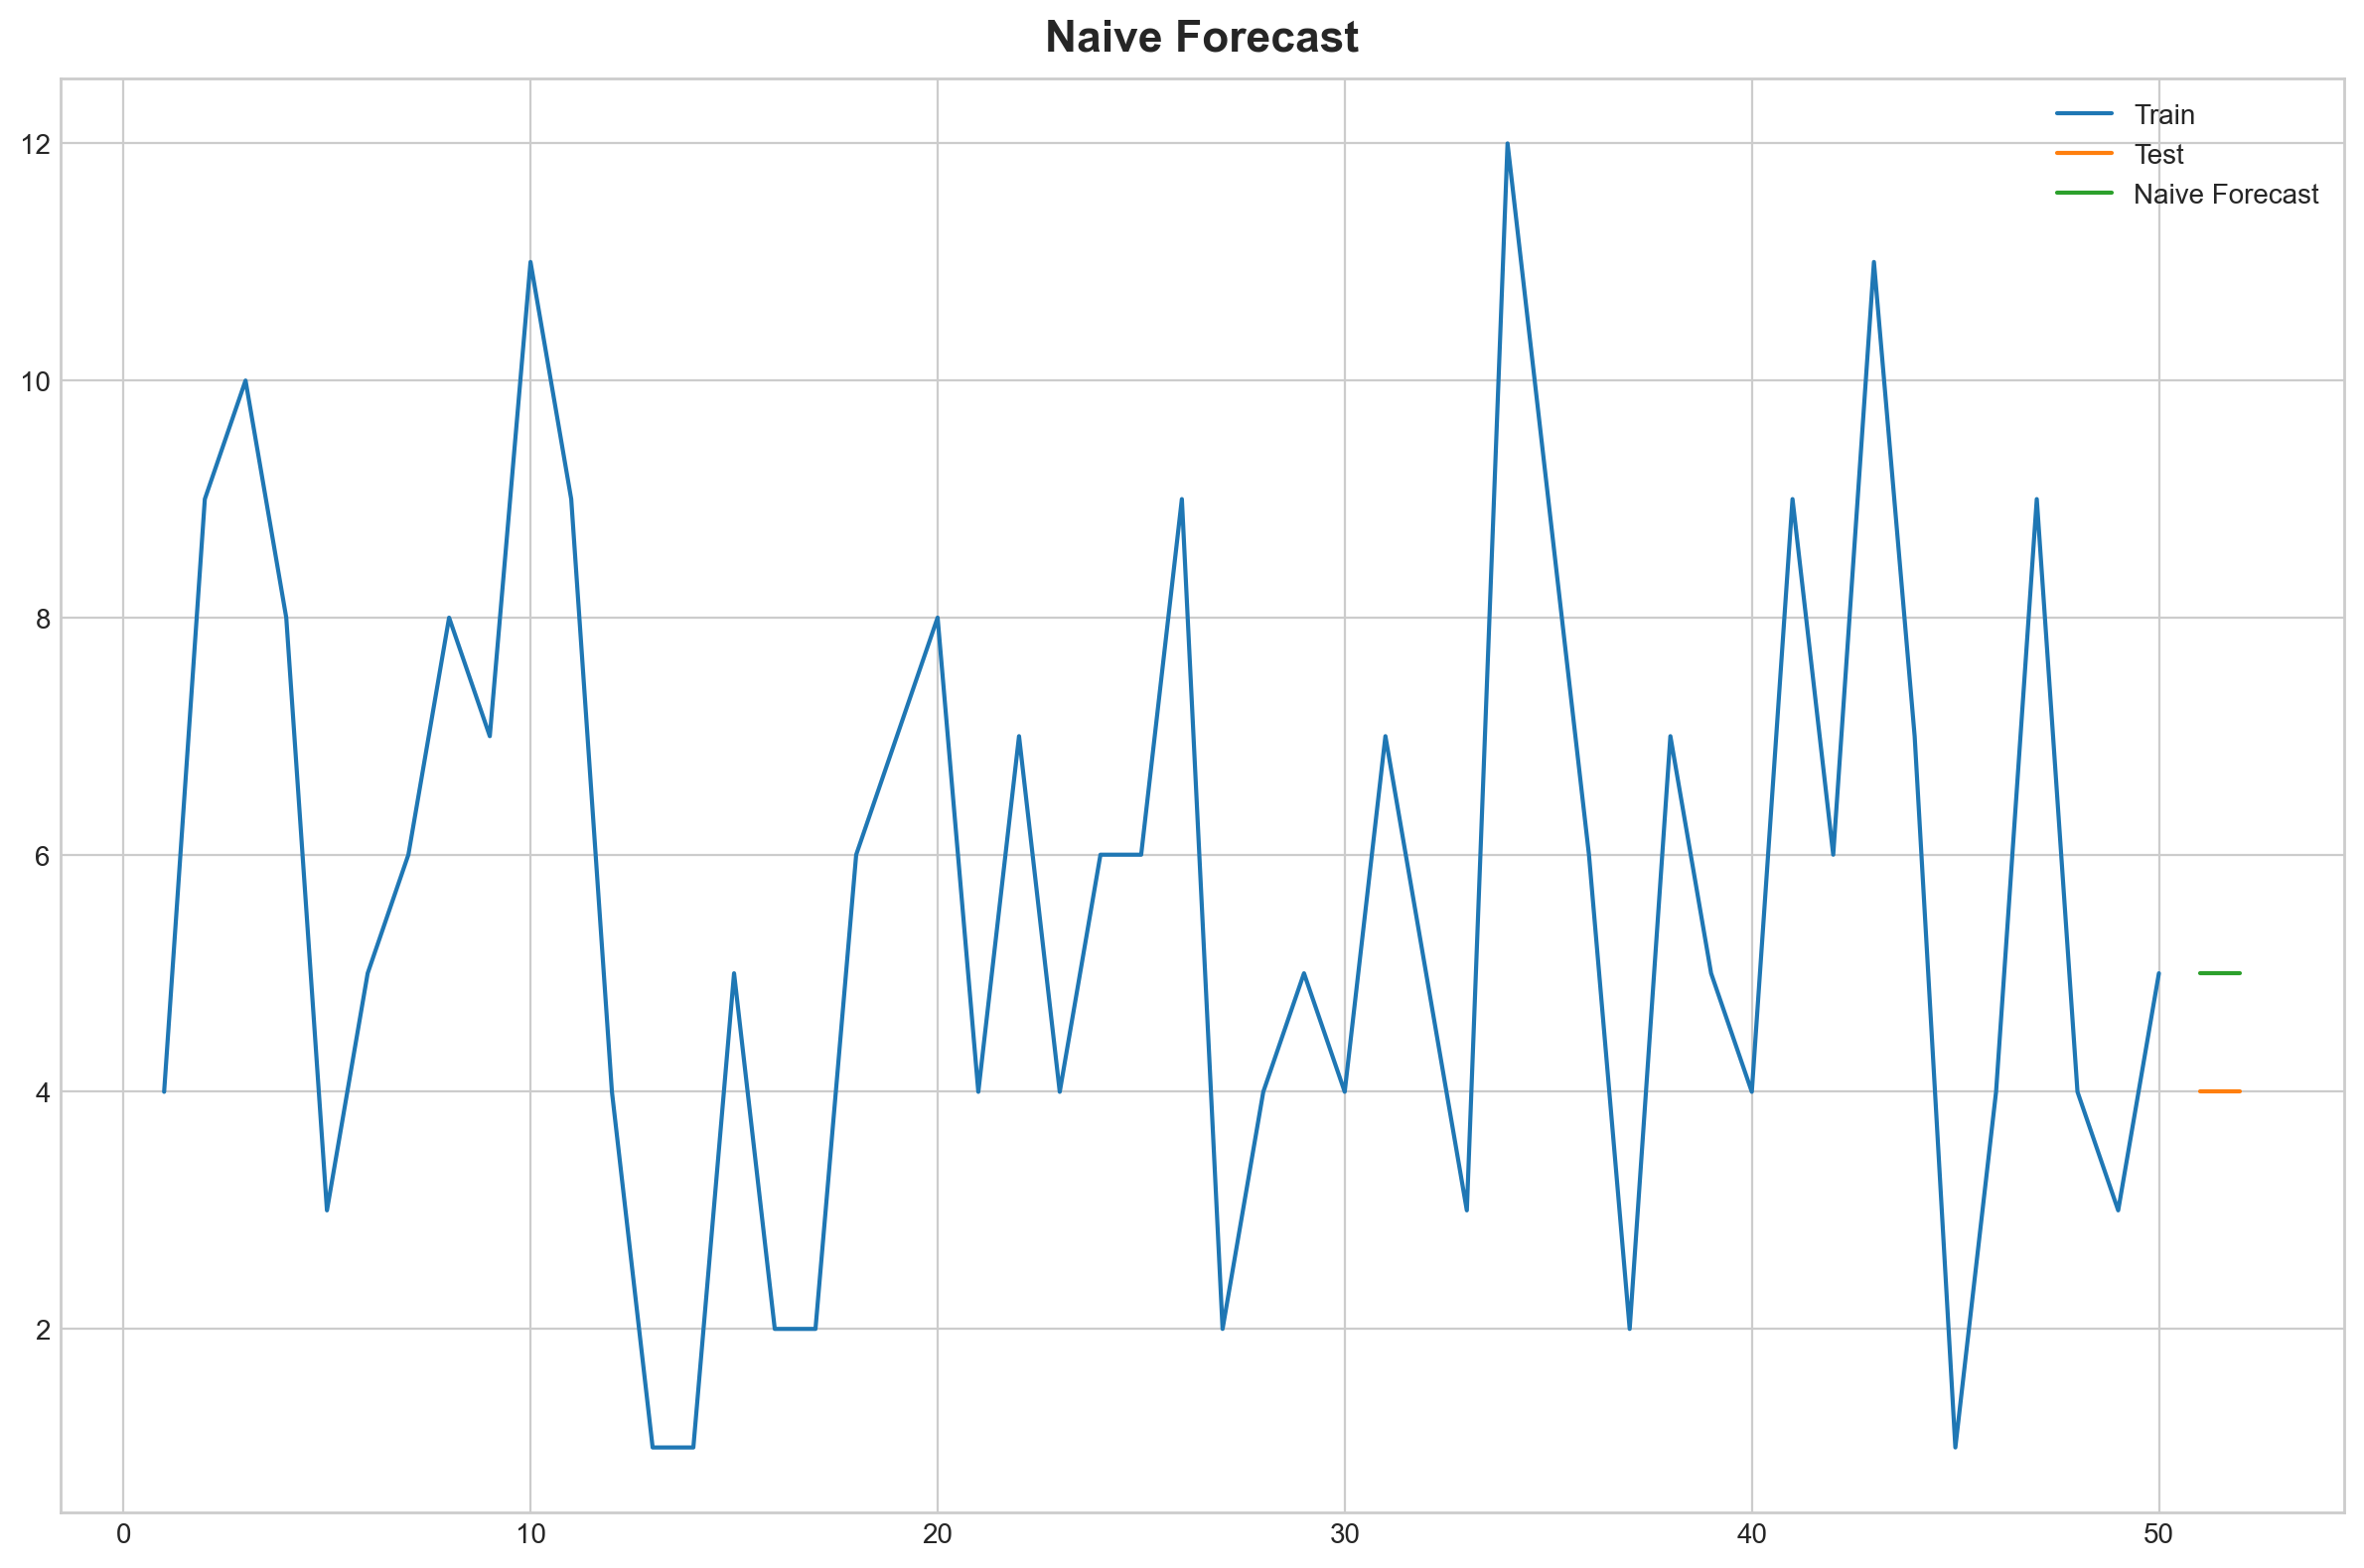

In [96]:
dd= np.asarray(X_train.burglary_count)
y_hat = X_test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(X_train.index, X_train['burglary_count'], label='Train')
plt.plot(X_test.index,X_test['burglary_count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [53]:
rmse = sqrt(mean_squared_error(X_test.burglary_count, y_hat.naive))
print("Root Mean Square Error based on Naive method: ",round(rmse,2))

Root Mean Square Error based on Naive method:  1.0


### Simple Average Method<a id='avg_method'>

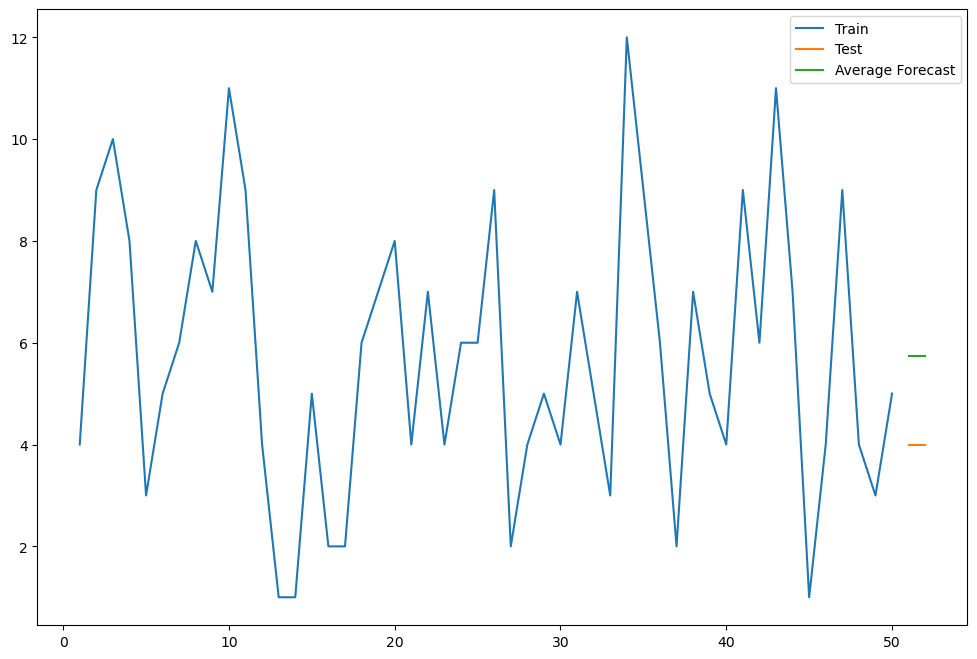

In [54]:
y_hat_avg = X_test.copy()
y_hat_avg['avg_forecast'] = X_train['burglary_count'].mean()
plt.figure(figsize=(12,8))
plt.plot(X_train['burglary_count'], label='Train')
plt.plot(X_test['burglary_count'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [55]:
rmse = sqrt(mean_squared_error(X_test.burglary_count, y_hat_avg.avg_forecast))
print("Root Mean Square Error based on Simple Average method: ",round(rmse,2))

Root Mean Square Error based on Simple Average method:  1.73


### Moving Average Method<a id='moving_avg_method'>

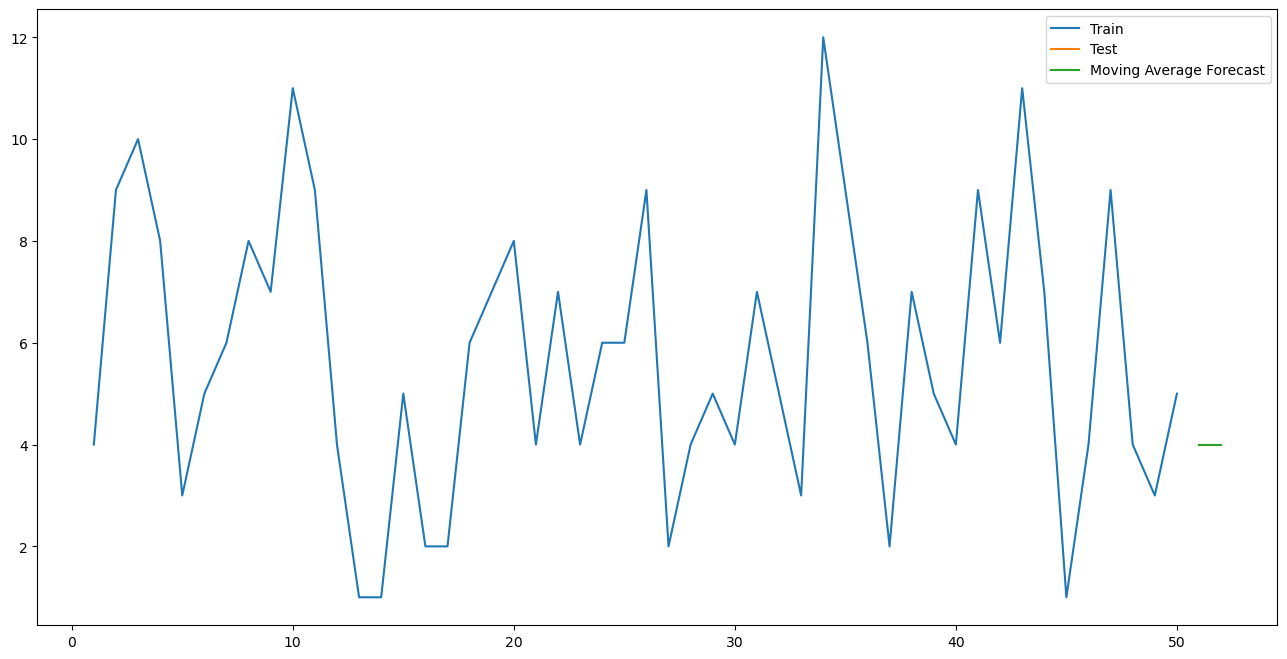

In [56]:
y_hat_avg = X_test.copy()
y_hat_avg['moving_avg_forecast'] = X_train['burglary_count'].rolling(3).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(X_train['burglary_count'], label='Train')
plt.plot(X_test['burglary_count'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [57]:
rmse = sqrt(mean_squared_error(X_test.burglary_count, y_hat_avg.moving_avg_forecast))
print("Root Mean Square Error based on Moving Average method: ",round(rmse,2))

Root Mean Square Error based on Moving Average method:  0.0


### Simple Exponential Smoothing Method<a id='simple_exponential_method'>
<br />Exponential smoothing is a method for forecasting univariate time series data. <br />
It is based on the principle that a prediction is a weighted linear sum of past observations or lags.<br />
The Exponential Smoothing time series method works by assigning exponentially decreasing weights for past observations.

In [58]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

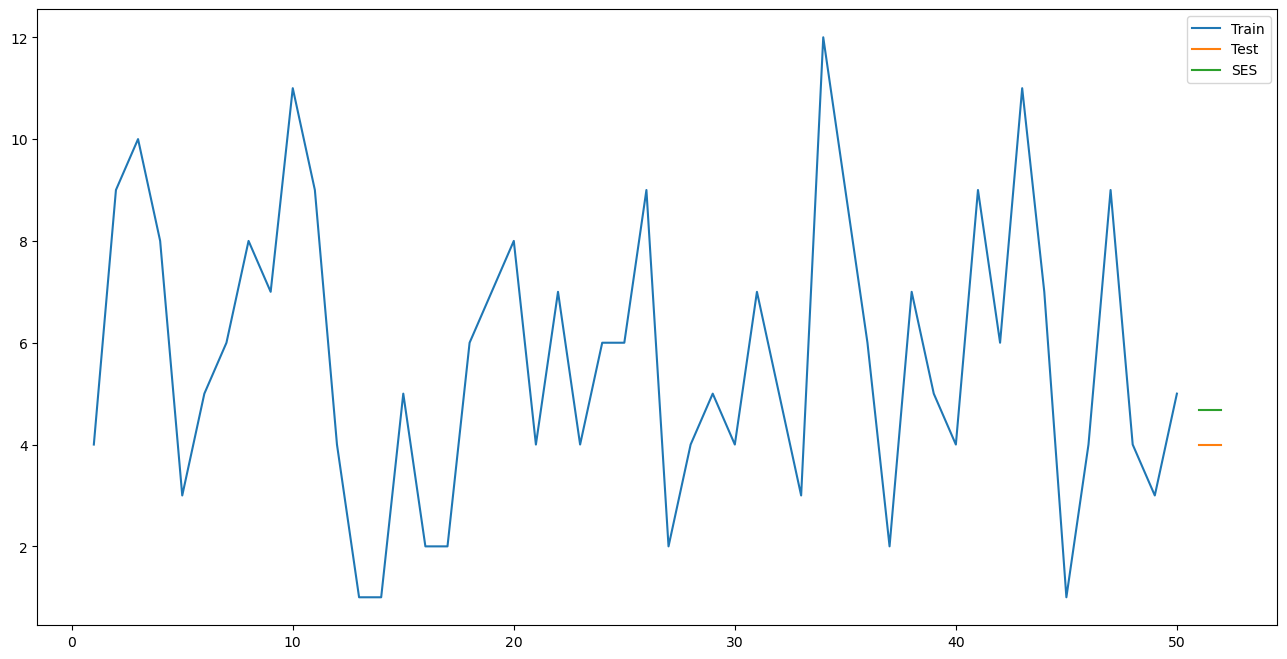

In [59]:
y_hat_avg = X_test.copy()
fit2 = SimpleExpSmoothing(np.asarray(X_train['burglary_count'])).fit(smoothing_level=0.8,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(X_test))
plt.figure(figsize=(16,8))
plt.plot(X_train['burglary_count'], label='Train')
plt.plot(X_test['burglary_count'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [60]:
rmse = sqrt(mean_squared_error(X_test.burglary_count, y_hat_avg.SES))
print("Root Mean Square Error based on Simple Exponential Smoothing method: ",round(rmse,2))

Root Mean Square Error based on Simple Exponential Smoothing method:  0.67


##### For Exponential Smoothing, I tried with 0.6 and 0.8 for smoothing_level and observed that 0.8 smoothing_level gave a lower RMSE value and hence will keep 0.8. 

### Autocorrelation and Partial Autocorrelation plots<a id='acf_pacf'>

Draw a partial autocorrelation graph(ACF) of the data. This will help us in finding the value of p because the cut-off point to the PACF is p. 
Draw an autocorrelation graph(ACF) of the data. This will help us in finding the value of q because the cut-off point to the ACF is q.  

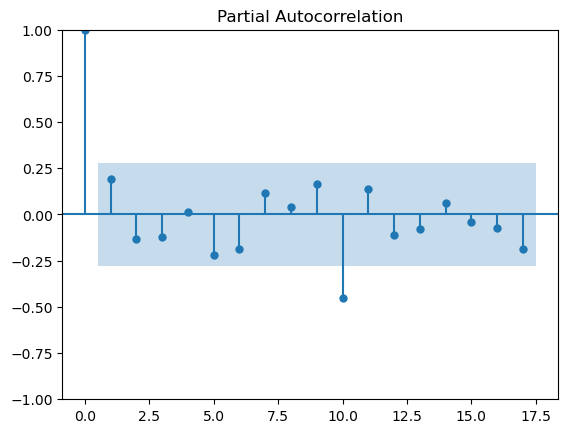

In [61]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(np.array(X_train.burglary_count))
plt.show()

### From the above graph, I will choose AR(1) model

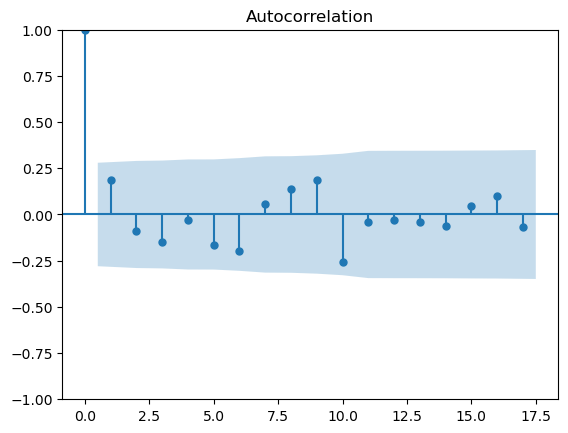

In [62]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(np.array(X_train.burglary_count))
plt.show()

### From the above plot, I will consider MA(0) model

In [63]:
from pmdarima.arima.utils import ndiffs

ndiffs(X_train)

0

#####  order of differencing as per above result. d=0

In [64]:
from pmdarima.arima import nsdiffs
nsdiffs(X_train,12)

0

##### No seasonality as per above result

### Therefore the values of p, d and q, based on the above acf and pacf plots, I am going to consider, p=1, d=0, q=1

### ARIMA Modeling<a id='arima_modeling'>

In [65]:
model = ARIMA(X_train, order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         burglary_count   No. Observations:                   49
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -118.674
Date:                Thu, 09 Mar 2023   AIC                            243.349
Time:                        08:58:14   BIC                            249.024
Sample:                             0   HQIC                           245.502
                                 - 49                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7232      0.490     11.687      0.000       4.763       6.683
ar.L1          0.1868      0.165      1.130      0.258      -0.137       0.511
sigma2         7.4279      1.824      4.073      0.0

In [66]:
# make predictions using forecast method
predictions_f_ms = model_fit.forecast(steps=len(X_test))
rmse = mean_squared_error(X_test.burglary_count, predictions_f_ms)
print("Root Mean Square Error based on ARIMA method(forecast): ",round(rmse,2))

Root Mean Square Error based on ARIMA method(forecast):  2.7


In [67]:
# make predictions using predict method
predictions_p_ms = model_fit.predict(start=len(X_train), end=len(X_train)+len(X_test)-1)
rmse = mean_squared_error(X_test.burglary_count, predictions_p_ms)
print("Root Mean Square Error based on ARIMA method(predict method): ",round(rmse,2))

Root Mean Square Error based on ARIMA method(predict method):  2.7


##  'auto_arima' grid search to find the best paramaters for our model<a id='auto_arima_grid'>

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=243.108, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=243.349, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=243.019, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=322.531, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=245.005, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=244.980, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=246.869, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=294.843, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.170 seconds


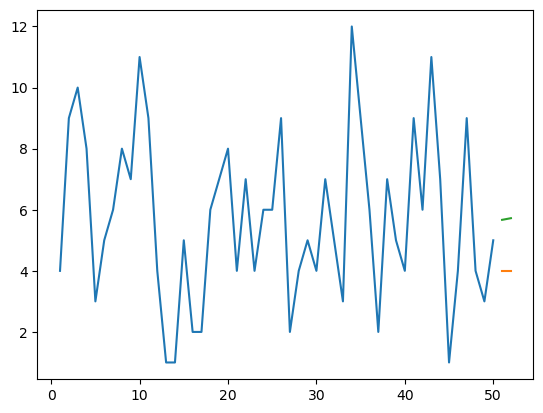

In [68]:
model = auto_arima(X_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(X_train)

forecast = model.predict(n_periods=len(X_test))
forecast = pd.DataFrame(forecast,index = X_test.index,columns=['burglary_count'])

#plot the predictions for validation set
plt.plot(X_train, label='Train')
plt.plot(X_test, label='Test')
plt.plot(forecast, label='Burglary Count')
plt.show()

In [69]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   49
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -118.510
Date:                Thu, 09 Mar 2023   AIC                            243.019
Time:                        08:58:14   BIC                            248.695
Sample:                             0   HQIC                           245.173
                                 - 49                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.7237      0.490     11.680      0.000       4.763       6.684
ma.L1          0.2139      0.167      1.277      0.202      -0.114       0.542
sigma2         7.3765      1.819      4.055      0.000       3.811      10.942
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.14
Prob(Q):                              0.98   Prob(JB):                         0.57
Heteroskedasticity (H):               0.88   Skew:                             0.31
Prob(H) (two-sided):                  0.80   Kurtosis:                         2.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [70]:
rmse = sqrt(mean_squared_error(X_test,forecast))
print(rmse)

1.696829093265205


### Linear Regression<a id='linear_regression'>

In [71]:
df_burglary_22_gp['Time'] = np.arange(len(df_burglary_22_gp.index))

df_burglary_22_gp.head()

weekNumber  burglary_count  Time
0           1               4     0
1           2               9     1
2           3              10     2
3           4               8     3
4           5               3     4

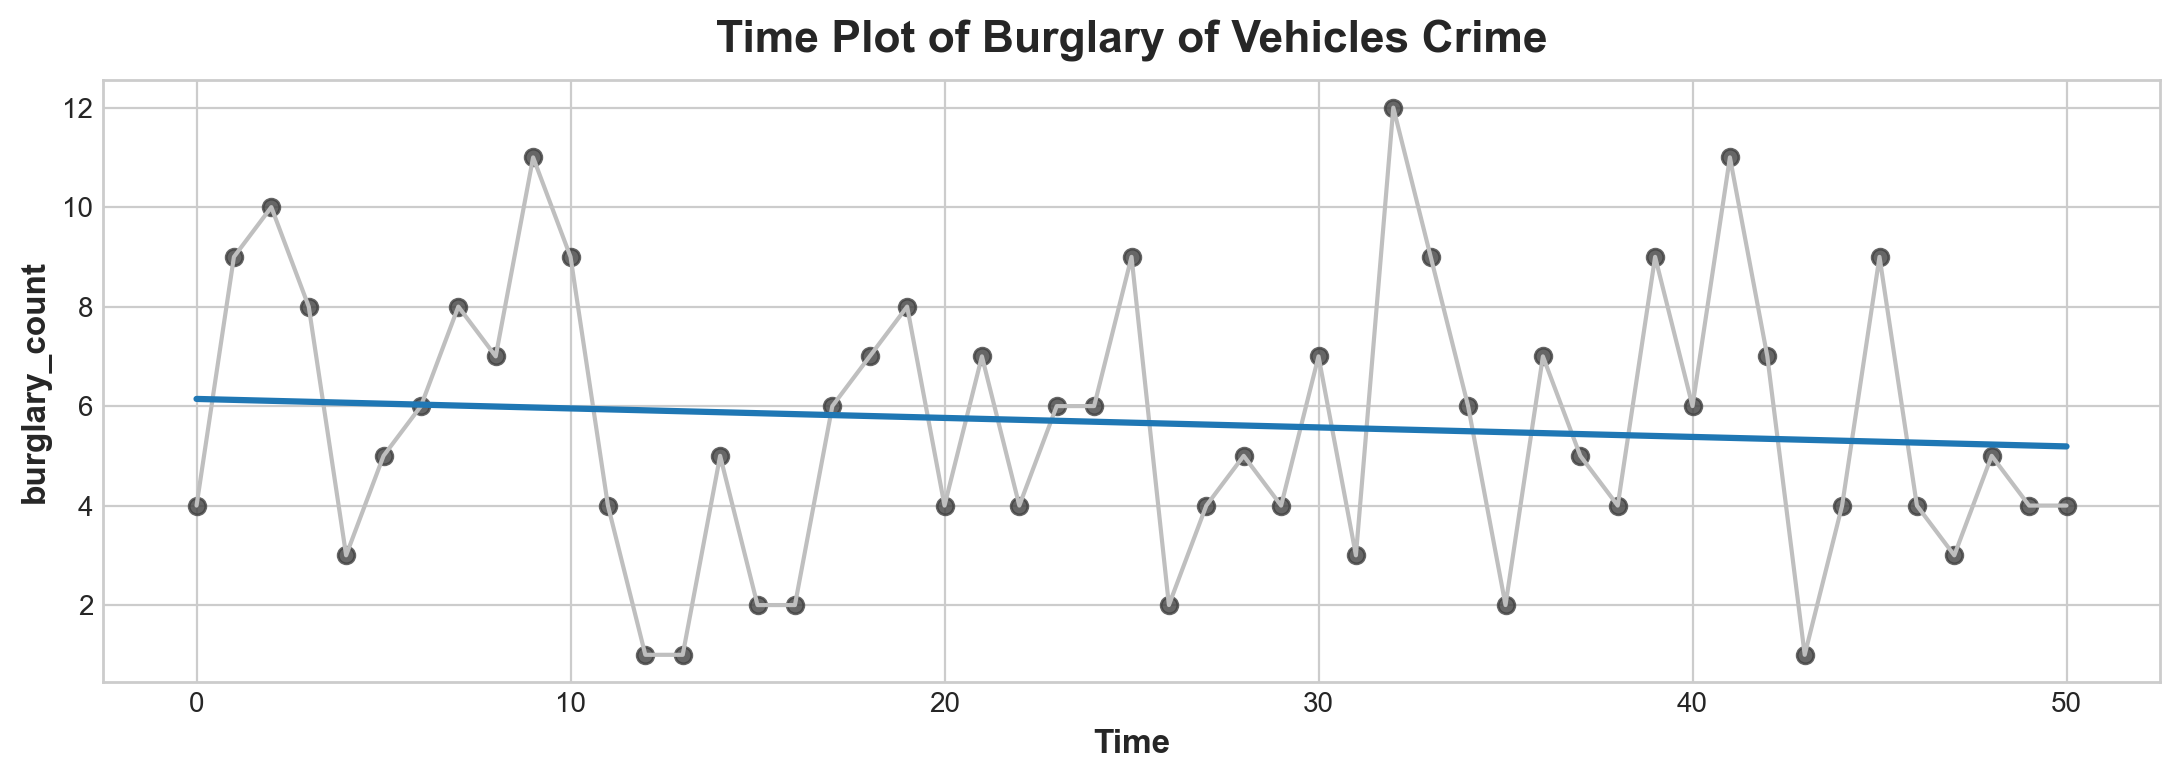

In [72]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'burglary_count', data=df_burglary_22_gp, color='0.75')
ax = sns.regplot(x='Time', y='burglary_count', data=df_burglary_22_gp, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Burglary of Vehicles Crime');

### Lag Features

In [73]:
df_burglary_22_gp['Lag_1'] = df_burglary_22_gp['burglary_count'].shift(1)
df_burglary_22_gp = df_burglary_22_gp.reindex(columns=['burglary_count', 'Lag_1','Time','weekNumber'])

df_burglary_22_gp.head()

burglary_count  Lag_1  Time  weekNumber
0               4    NaN     0           1
1               9    4.0     1           2
2              10    9.0     2           3
3               8   10.0     3           4
4               3    8.0     4           5

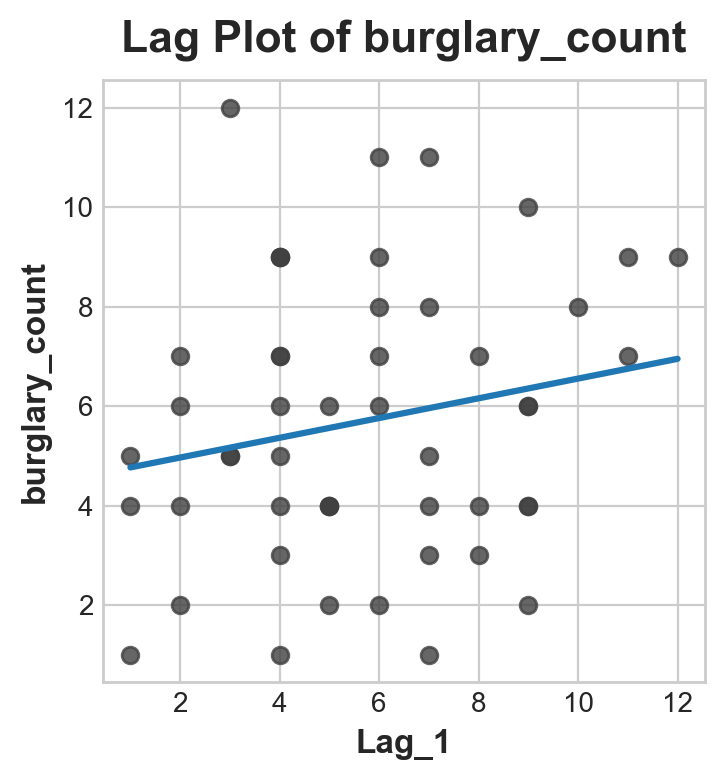

In [74]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='burglary_count', data=df_burglary_22_gp, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of burglary_count');

### Based on the above plots, it is very clear that there is no correlation of the current theft_count to the past values. Forecasting cannot be accomplished withthis time series. 

In [79]:
from sklearn.linear_model import LinearRegression

# Training data
X = df_burglary_22_gp.loc[:, ['Lag_1']]  # features
X.dropna(inplace=True)
y = df_burglary_22_gp.loc[:, 'burglary_count']  # target
y, X = y.align(X, join='inner') 
# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

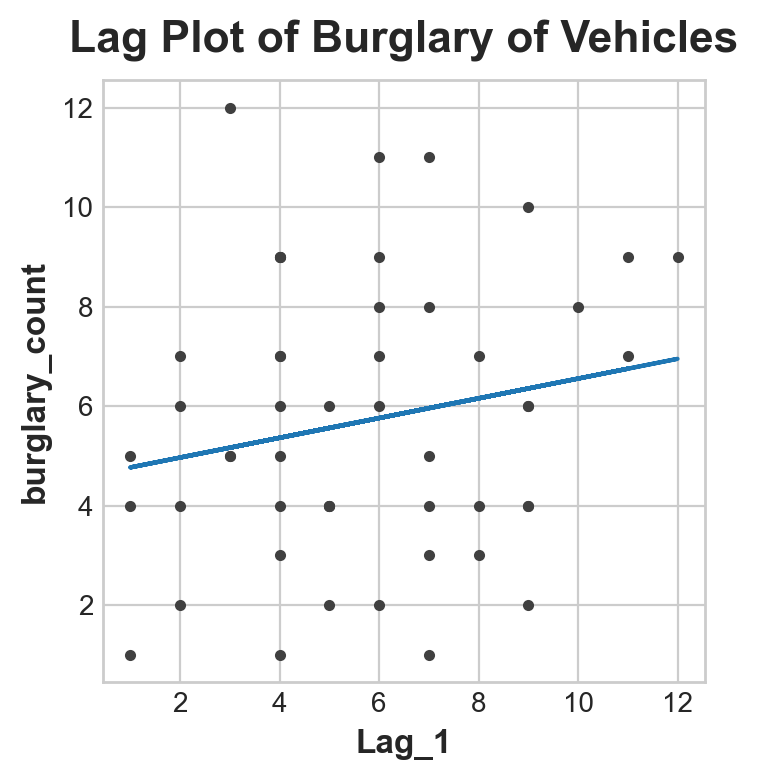

In [80]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('burglary_count')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Burglary of Vehicles');

In [81]:
import sklearn.metrics as metrics


mae = metrics.mean_absolute_error(y_test, y)
mse = metrics.mean_squared_error(y_test, y)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(y,preds)

print("Results of Linear Regression:")

print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

ValueError: Found input variables with inconsistent numbers of samples: [2, 50]